In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from IPython.display import display
import numpy as np
import os
import torch
from PIL import Image, ImageDraw
from plotly.subplots import make_subplots

# SOMMAIRE

##### [Introduction](#dim)

##### I -  [Enveloppe](#Experiments)  
##### II -  [Time](#Time)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - [Methods comparaison](#Methodes)   
##### III -  [Global analysis IoU](#Complexity)

## Envelope

In [3]:
folder_path = "/Users/ncohmpli/Documents/Professionnel/Technical/Verification/Lirpa for IoU/manip/pipeline/lirpa_iou_pipeline/results/many_methods/"

In [4]:
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

In [5]:
dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, converters={"bounds_clip":pd.eval,  'IoU_vanilla':pd.eval,'IoU_extension':pd.eval,'IoU_extension_greedy':pd.eval})
    dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)

In [7]:
combined_df = combined_df.sort_values(by="image_id")

In [8]:
combined_df["lb_box"] = combined_df["bounds_clip"].apply(lambda x: x[0])
combined_df["lb_box0"] = combined_df["bounds_clip"].apply(lambda x: x[0][0])
combined_df["ub_box"] = combined_df["bounds_clip"].apply(lambda x: x[1])

In [9]:
combined_df["IoU_vanilla_delta"] = combined_df.IoU_vanilla.apply(lambda x: x[1]-x[0])
combined_df["IoU_extension_delta"] = combined_df.IoU_extension.apply(lambda x: x[1]-x[0])

combined_df["Vanilla_upper"] = combined_df.IoU_vanilla.apply(lambda x: x[1])
combined_df["Vanilla_lower"] = combined_df.IoU_vanilla.apply(lambda x: x[0])
combined_df["Extension_upper"] = combined_df.IoU_extension.apply(lambda x: x[1])
combined_df["Extension_lower"] = combined_df.IoU_extension.apply(lambda x: x[0])

In [10]:
eps0 = combined_df[combined_df["eps"]==0]
bad_images_extension = np.unique(eps0[eps0["IoU_extension_delta"]>0.0001]["image_id"])
bad_images_vanilla = np.unique(eps0[eps0["IoU_vanilla_delta"]>0.0001]["image_id"])
def bad_images(im):
    if (im in bad_images_extension) or (im in bad_images_vanilla):
        return(True)
    return(False)
combined_df["bad_images"] = combined_df["image_id"].apply(lambda x: bad_images(x))
combined_df = combined_df[combined_df["bad_images"] == False]

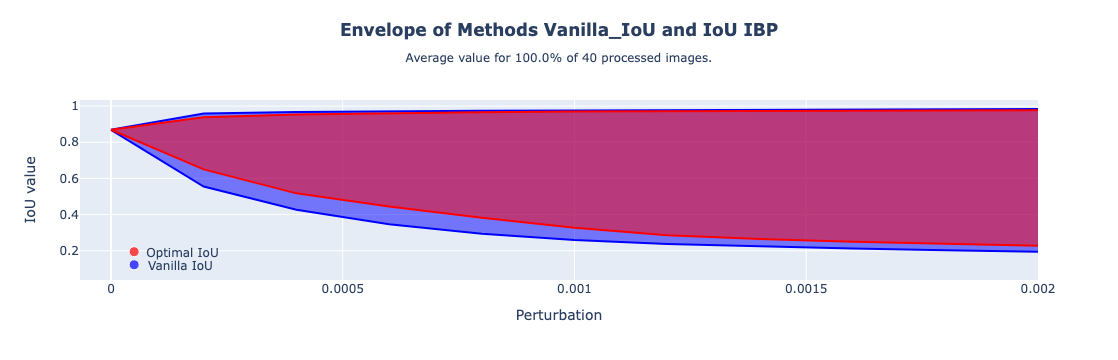

In [17]:
def envelop_graph(df_grouped, eps="eps", title='Envelope of Methods Vanilla_IoU and IoU IBP', subtitle=None, subsubtitle=""):
    """df should have the columns
    "Eps" "Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"
    """

    trace_A = go.Scatter(
        x=df_grouped[eps],
        y=df_grouped["Vanilla_upper"],
        fill=None,
        mode='lines',
        line=dict(color='blue'),
        name='Vanilla_IoU Upper Bound', 
        showlegend=False
    )
    trace_A_lower = go.Scatter(
        x=df_grouped[eps],
        y=df_grouped["Vanilla_lower"],
        fill='tonexty',  # Espace remplissage ! 
        mode='lines',
        line=dict(color='blue'),
        name='Vanilla_IoU Lower Bound',
        showlegend=False
    )
    trace_B = go.Scatter(
        x=df_grouped[eps],
        y=df_grouped["Extension_upper"],
        fill=None,
        mode='lines',
        line=dict(color='red'),
        name='IoU_extension Upper Bound',
        showlegend=False
    )
    trace_B_lower = go.Scatter(
        x=df_grouped[eps],
        y=df_grouped["Extension_lower"],
        fill='tonexty',  # Espace remplissage ! 
        mode='lines',
        line=dict(color='red'),
        name='IoU_extension Lower Bound',
        showlegend=False
    )
    
    layout = go.Layout(
        title=title,
        xaxis=dict(title='Perturbation'),
        yaxis=dict(title='IoU value')
    )
    
    fig = go.Figure(layout=layout)
    fig.add_trace(trace_A)
    fig.add_trace(trace_A_lower)
    fig.add_trace(trace_B)
    fig.add_trace(trace_B_lower)

    decalou = (df_grouped["Extension_upper"].max()-df_grouped["Extension_upper"].min())/1.5
    x_vanilla, x_optimal = df_grouped[eps].describe()["25%"]/10, df_grouped[eps].describe()["25%"]/10
    y_vanilla, y_optimal = df_grouped["Vanilla_lower"].min()-decalou, df_grouped["Vanilla_lower"].min()
    decalage = df_grouped[eps].describe()["25%"]/5
    
    fig.add_trace(go.Scatter(
    x=[x_vanilla,x_optimal],
    y=[y_vanilla, y_optimal],
    mode='markers',
    marker=dict(color=['blue', 'red'], size=[10, 10]),  # Ajustez la taille au besoin
    showlegend=False,
    hoverinfo='none'))

    annotations = [
    dict(x=x_vanilla+decalage, y=y_vanilla, xref="x", yref="y",
         text="Vanilla IoU", showarrow=False),
    dict(x=x_optimal+decalage, y=y_optimal, xref="x", yref="y",
         text=" Optimal IoU", showarrow=False)]



    fig.update_layout(annotations=annotations)

    if subtitle != None:
        fig.update_layout(
            title={'text': f'<b>{title}</b><br><sub>{subtitle}</sub><br><sub><i>{subsubtitle}</i></sub>',
           'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'}
            )


    return(fig)

df_grouped = combined_df.groupby(["eps", "eps_contrast"])[["Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"]].agg("mean")
df_grouped = df_grouped.reset_index()

def percentage_value(df_plotted, df=df):
    """Percentage images processed on this plot
    """
    plotted = len(np.unique(list(df_plotted["image_id"])))
    globaldf = len(np.unique(list(df["image_id"])))
    return((plotted/globaldf)*100)
nb_im_proc = combined_df.groupby("image_id")[["eps"]].agg("count").shape[0]
envelop_graph(df_grouped, eps="eps", title=f'Envelope of Methods Vanilla_IoU and IoU IBP', subtitle=f"Average value for {percentage_value(df)}% of {nb_im_proc} processed images.")

In [19]:
dico_pert={}
for perturbation_i in np.unique(combined_df["perturbation"]):
    dico_pert[perturbation_i] = combined_df[combined_df["perturbation"] == perturbation_i]

In [20]:
eps_pert_dict = {'brightness':"eps", 'contrast':"eps_contrast", 'whitenoise':"eps"}

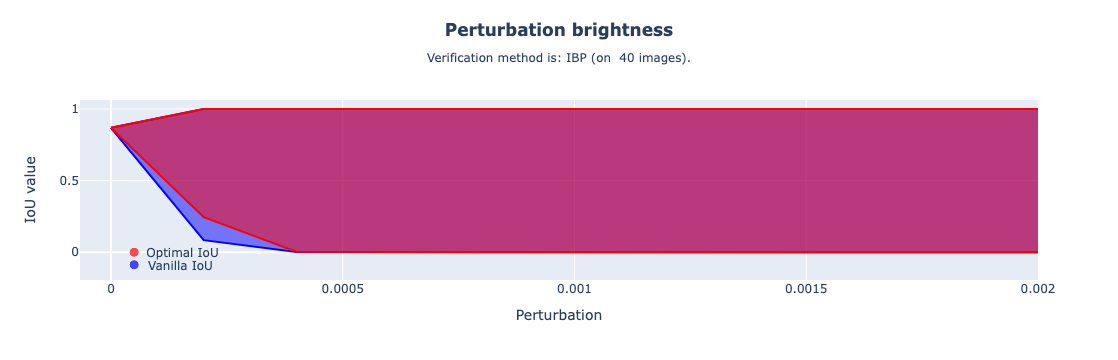

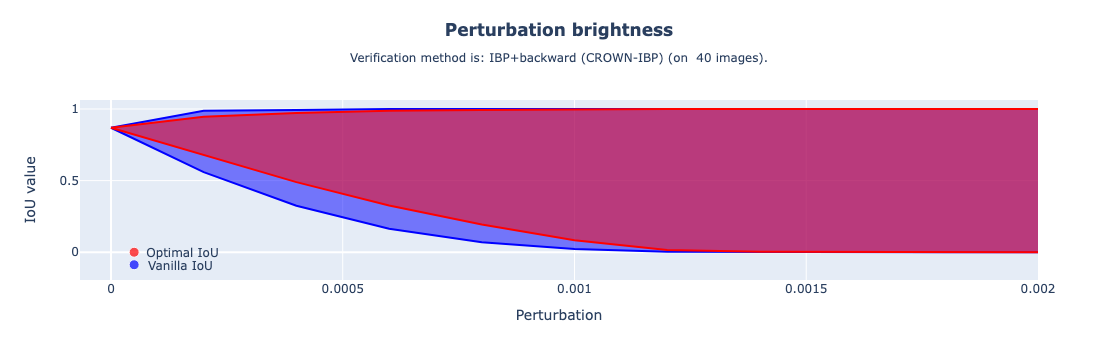

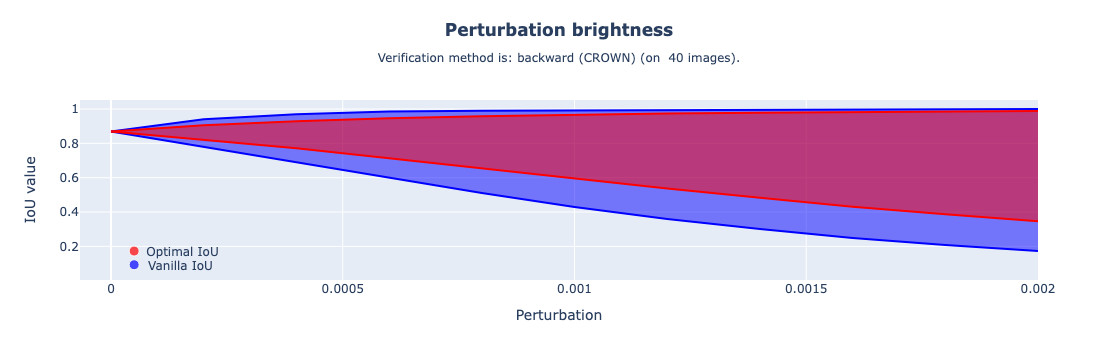

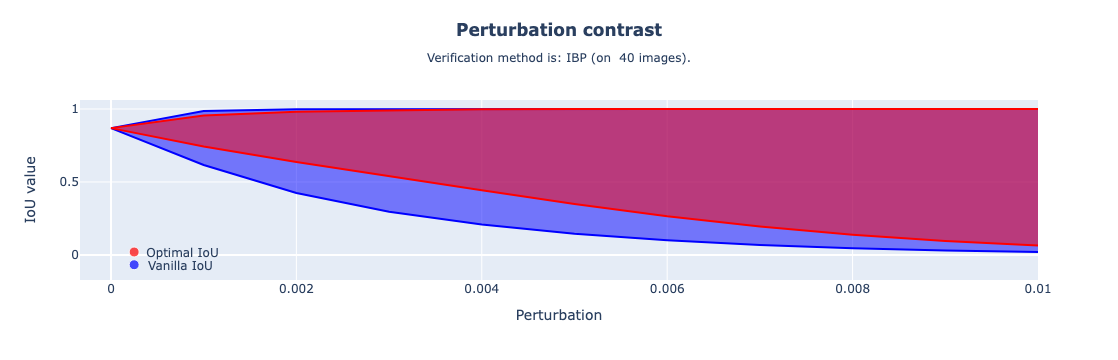

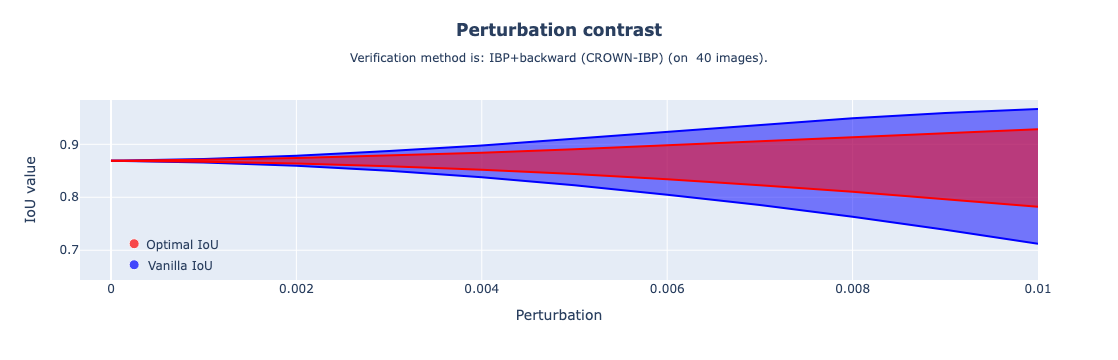

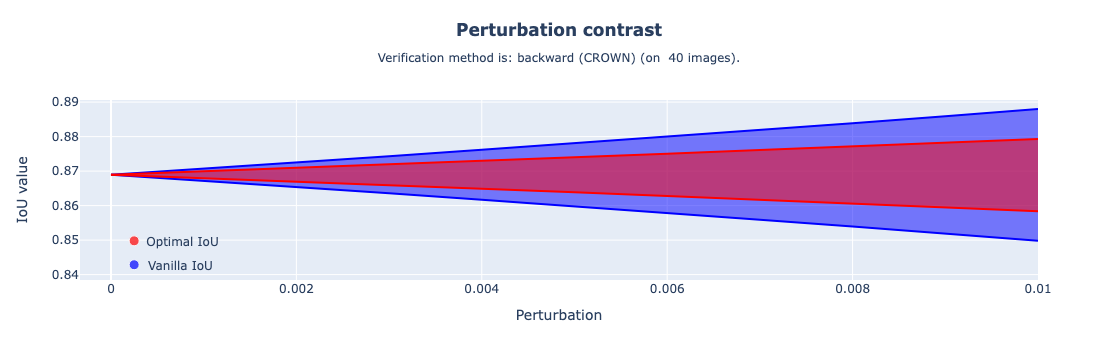

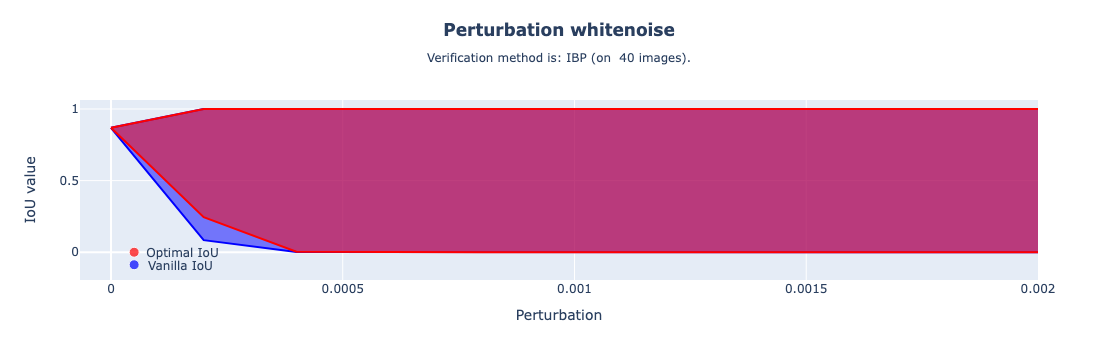

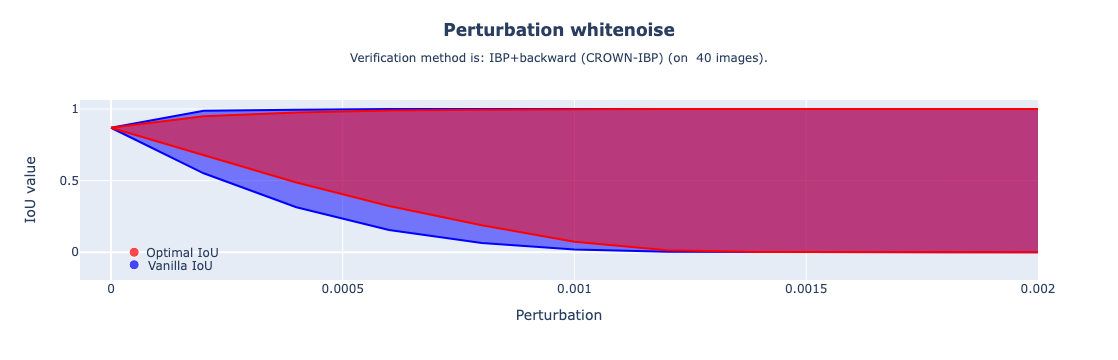

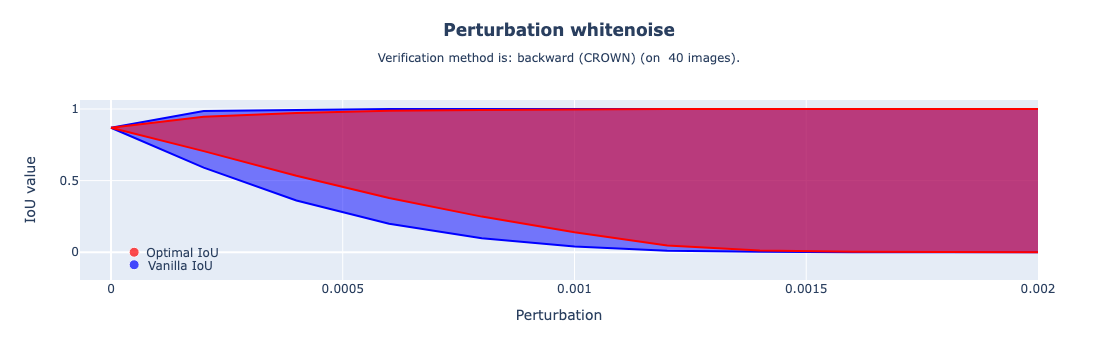

In [22]:
fig_pert_dict = {'brightness':[], 'contrast':[], 'whitenoise':[]}
for pert, eps_type in eps_pert_dict.items():
    for method in np.unique(combined_df.method):
        df_grouped = combined_df[(combined_df["perturbation"] == pert) & (combined_df["method"] == method)].groupby(["eps","eps_contrast"] )[["Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"]].agg("mean")
        df_grouped = df_grouped.reset_index()
        nb_im_proc = combined_df[(combined_df["perturbation"] == pert) & (combined_df["method"] == method)].groupby("image_id")[["eps"]].agg("count").shape[0]
        fig = envelop_graph(df_grouped, eps=eps_type, title=f'Perturbation {pert}', subtitle=f"Verification method is: {method} (on  {nb_im_proc} images).")
        fig.show()
        anotations = fig['layout']['annotations']
        fig_pert_dict[pert].append((fig.data, method, anotations))

In [23]:
pretty_names = {'brightness':'Brightness', 'contrast':'Contrast', 'whitenoise':'Whitenoise'}

In [24]:
fig_pert_dict_subplot = {}

for pert in fig_pert_dict.keys():
    fig = make_subplots(rows=3, cols=1, vertical_spacing=0.02)
    for i in range(len(fig_pert_dict[pert])):
        fig_i, method_i, annotation_i = fig_pert_dict[pert][i][0], fig_pert_dict[pert][i][1], fig_pert_dict[pert][i][2]
        for trace in fig_i:
            fig.add_trace(trace, row=1+i, col=1)
            fig.update_yaxes(title_text=method_i, row=1+i, col=1)
            
                
            #fig.update_layout(annotations=annotation_i)
            #fig['layout']['annotations'] = annotation_i
    fig.update_layout(height=1000, width=800)
    fig.update_xaxes(title_text=f"{pretty_names[pert]} perturbation", row=3, col=1)
    fig_pert_dict_subplot[pert] = fig

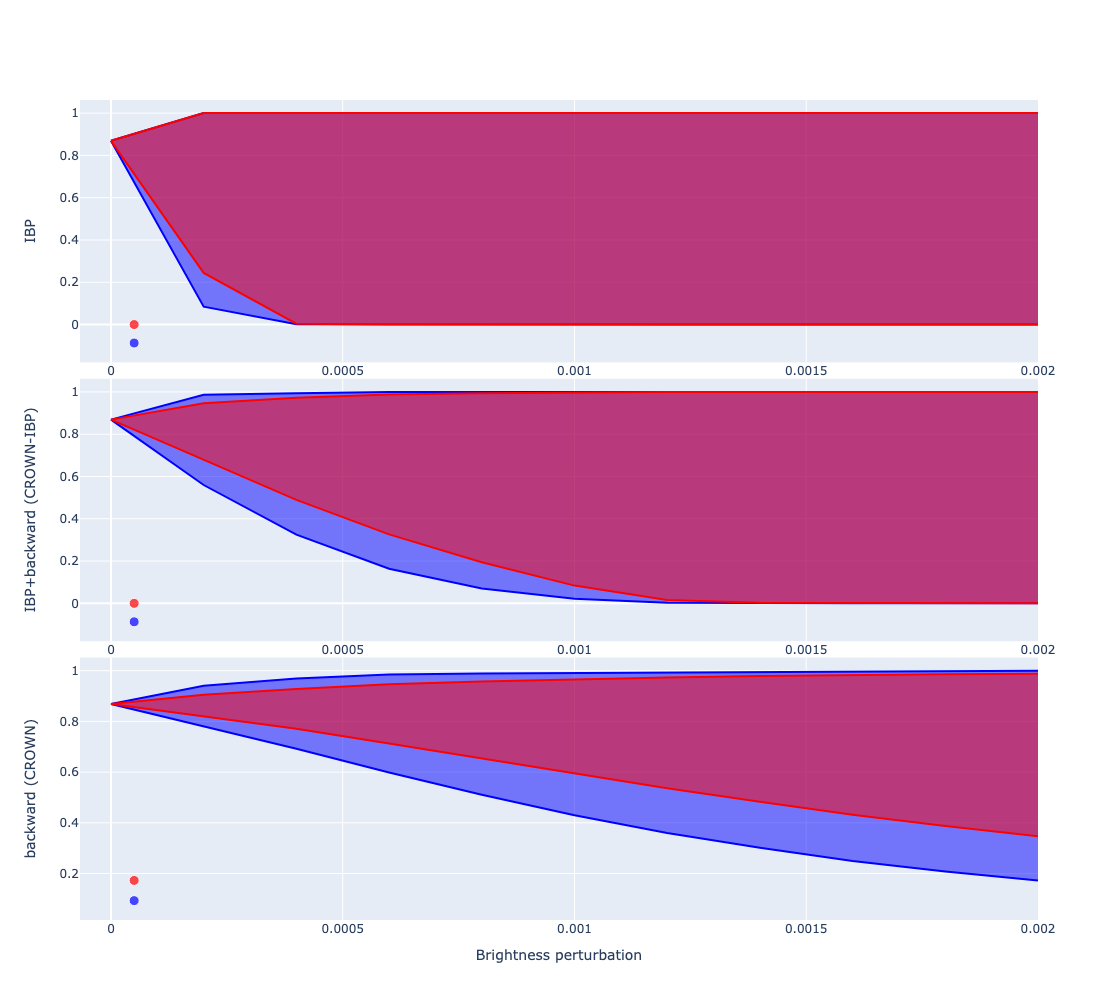

In [25]:
fig_1 = fig_pert_dict_subplot['brightness']
fig_1

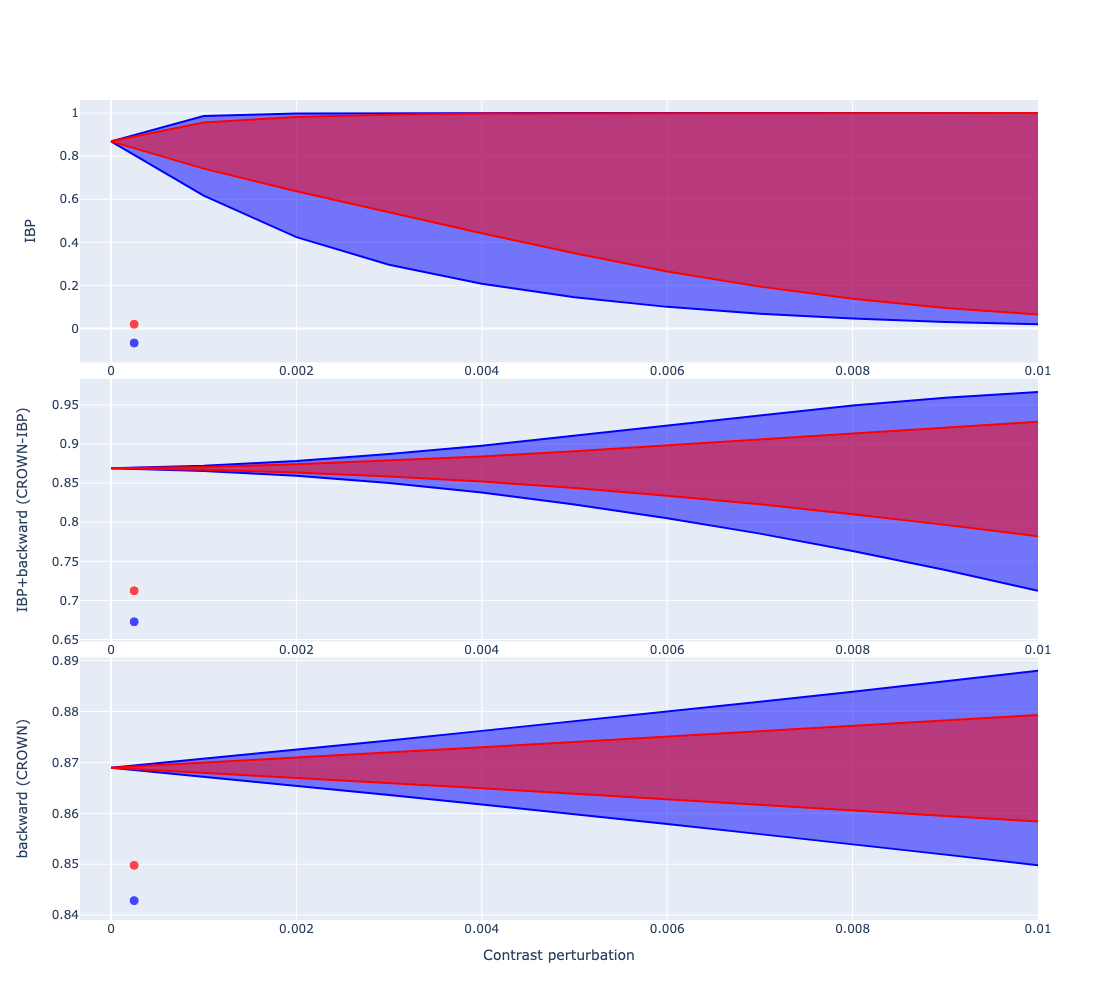

In [26]:
fig_pert_dict_subplot['contrast']

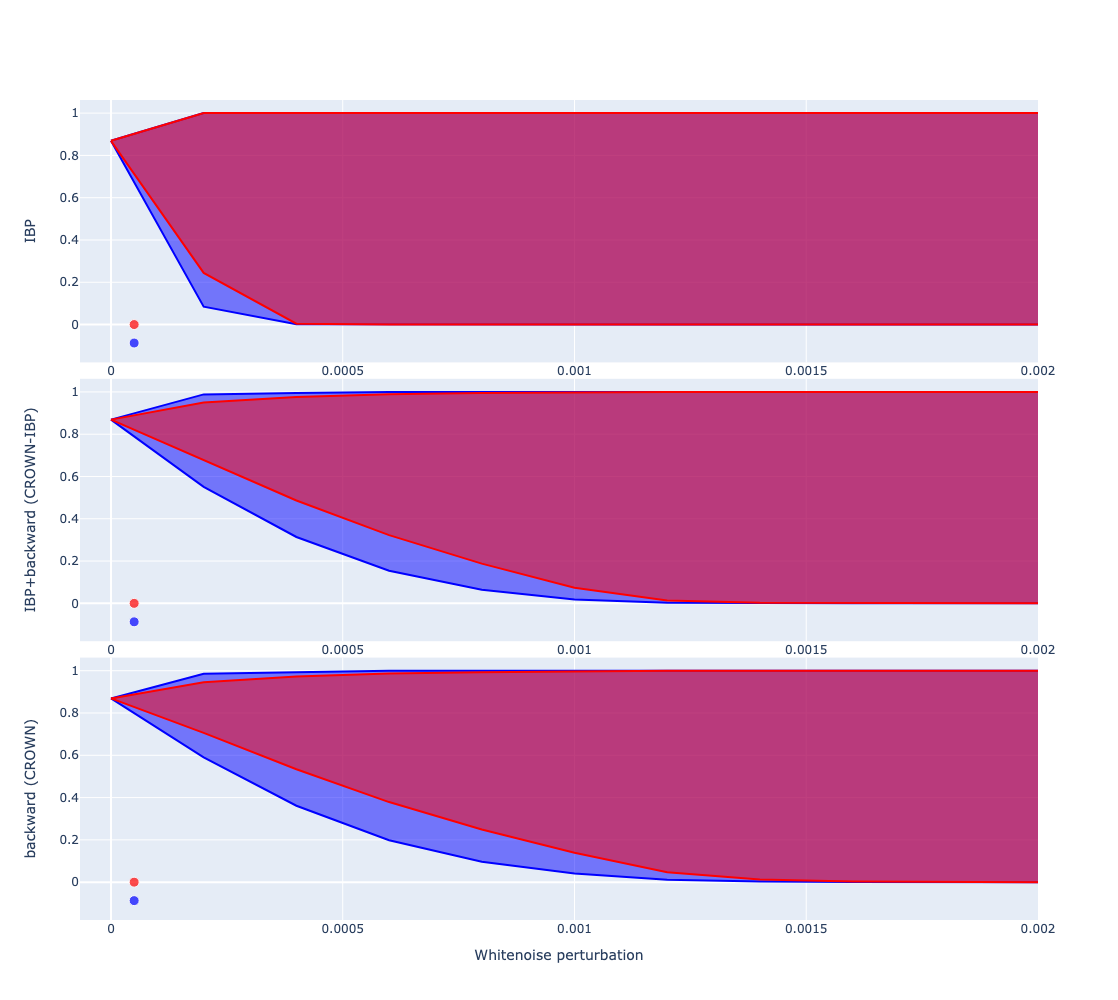

In [27]:
fig_pert_dict_subplot['whitenoise']

# <a id="Time"></a> Time analysis

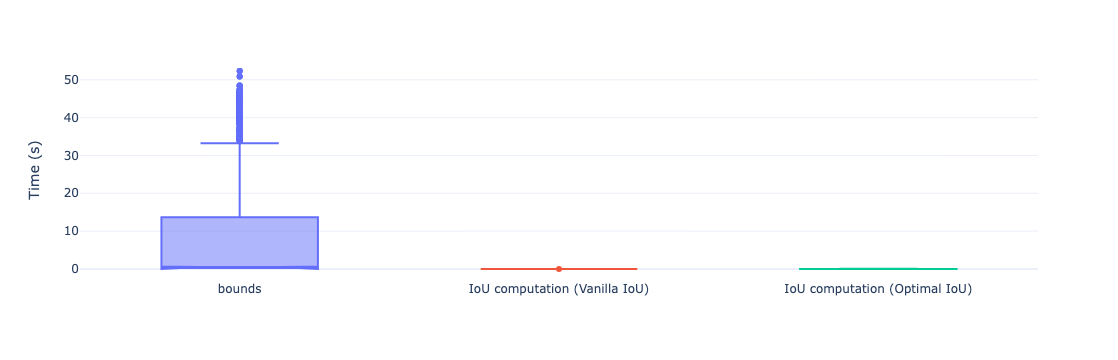

In [32]:
def create_box_plot(df, columns, return_V=False, without_melt=False, y_axes='Time (s)'):
    if without_melt==False:
        df = df.melt(value_vars=columns, var_name='Time', value_name='Value')
    fig = px.box(df, x='Time', y='Value', color='Time', 
                 notched=True,  
                 title='')

    fig.update_layout(
        yaxis_title=y_axes,  
        xaxis_title='',
        template='plotly_white',  
        showlegend=False  
    )
    if return_V==True:
        return(df)
    fig.show()

create_box_plot(combined_df.rename(columns={
    'elapsed_time_perturbation':'bounds',
    "tmps_vanilla":'IoU computation (Vanilla IoU)',
    "tmps_extension":'IoU computation (Optimal IoU)'}), ['bounds', 'IoU computation (Vanilla IoU)',	'IoU computation (Optimal IoU)'])

In [33]:
ious_ = create_box_plot(combined_df.rename(columns={
    "tmps_vanilla":'Vanilla IoU',
    "tmps_extension":'Optimal IoU'}), ['Optimal IoU', 'Vanilla IoU'], return_V=True)

df_CROWN_IBP = create_box_plot(combined_df[combined_df["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
    'elapsed_time_perturbation':'bounds (CROWN-IBP)',
    "tmps_vanilla":'Vanilla IoU',
    "tmps_extension":'Optimal IoU'}), ['bounds (CROWN-IBP)'], return_V=True)
df_CROWN = create_box_plot(combined_df[combined_df["method"] == 'backward (CROWN)'].rename(columns={
    'elapsed_time_perturbation':'bounds (CROWN)',
    "tmps_vanilla":'Vanilla IoU',
    "tmps_extension":'Optimal IoU'}), ['bounds (CROWN)'], return_V=True)
df_IBP = create_box_plot(combined_df[combined_df["method"] == 'IBP'].rename(columns={
    'elapsed_time_perturbation':'bounds (IBP)',
    "tmps_vanilla":'Vanilla IoU',
    "tmps_extension":'Optimal IoU'}), ['bounds (IBP)'], return_V=True)

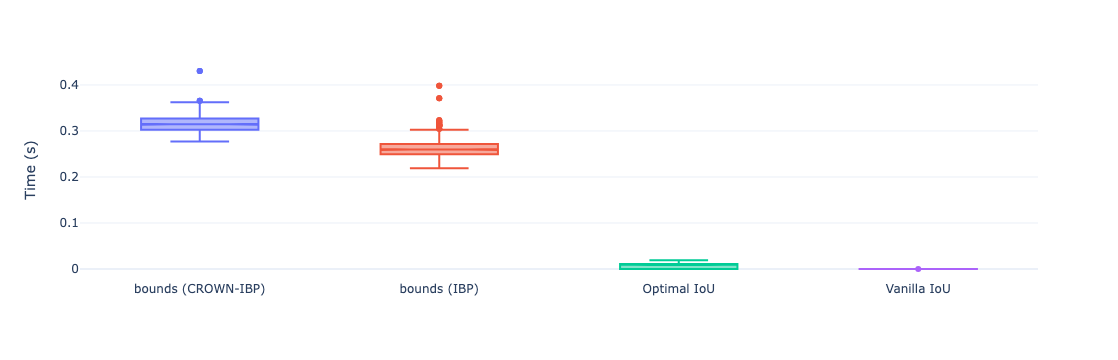

In [35]:
concat_methods = pd.concat([df_CROWN_IBP,df_IBP, ious_])
create_box_plot(concat_methods, columns=[""], return_V=False, without_melt=True)

epsilon 0.0


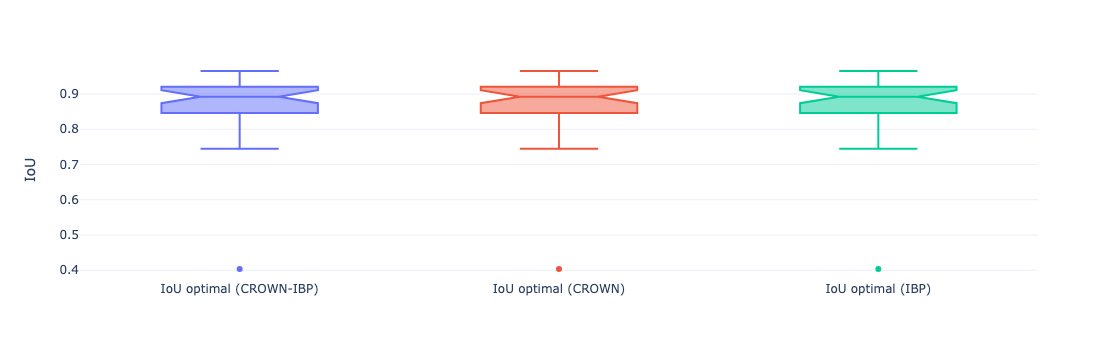

epsilon 0.0002


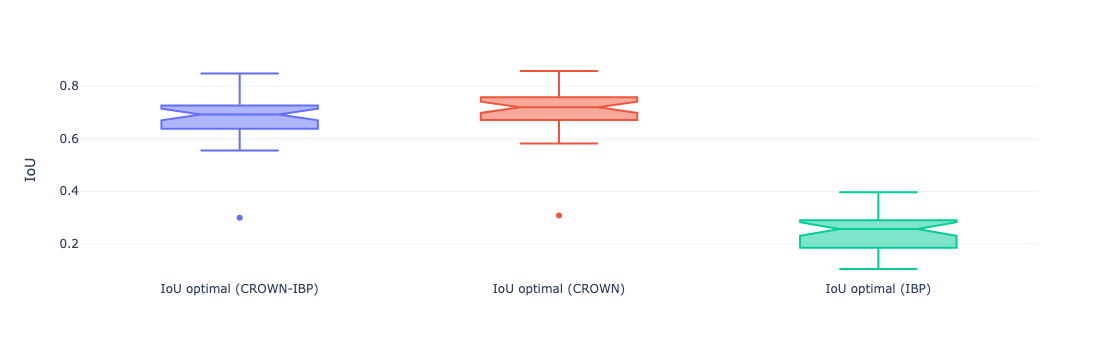

epsilon 0.0004


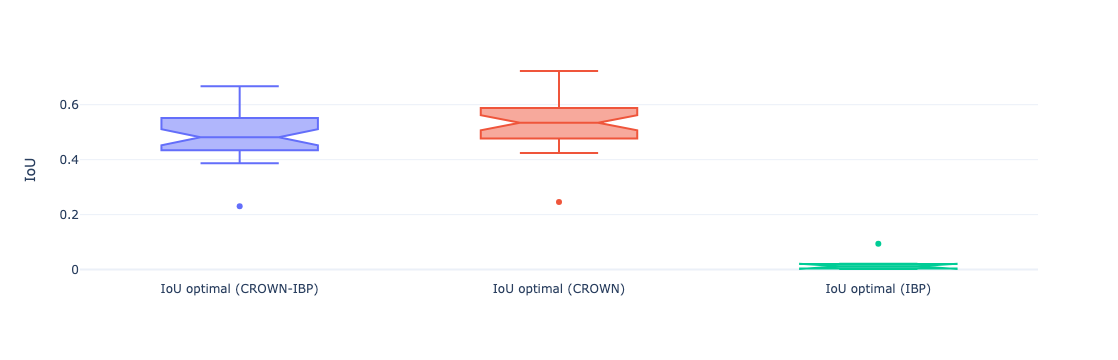

epsilon 0.0006


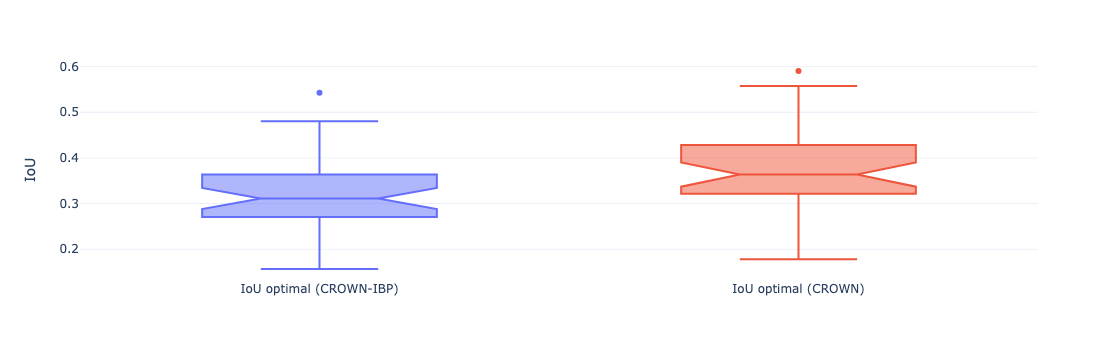

epsilon 0.0008


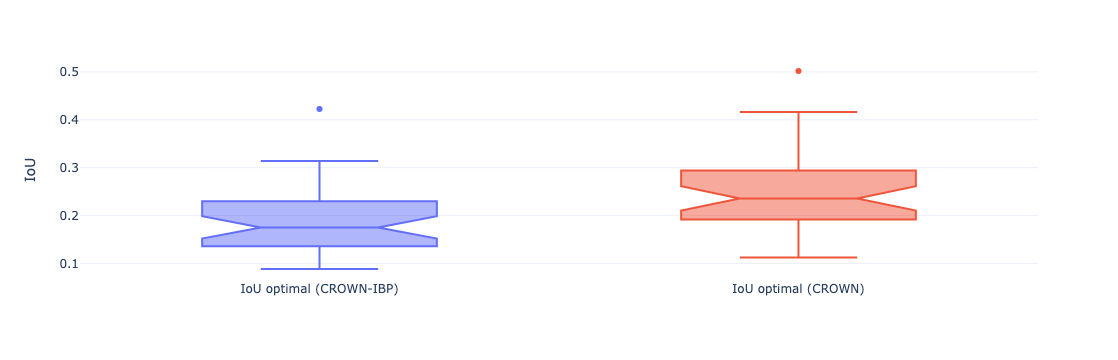

epsilon 0.001


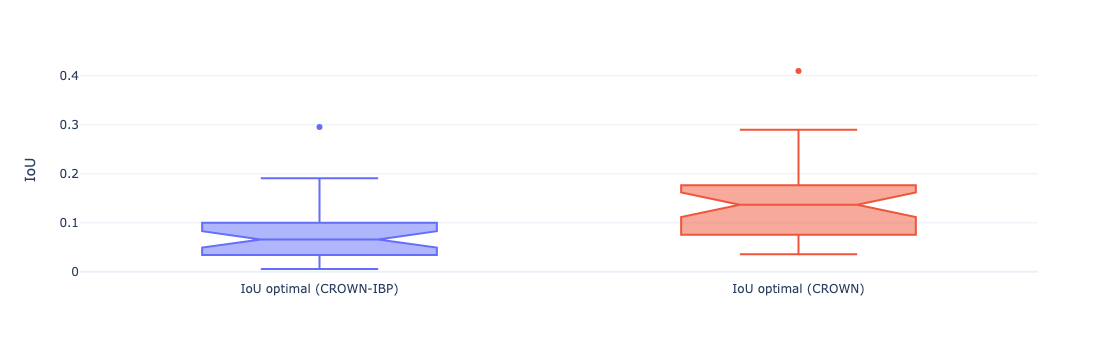

epsilon 0.0012


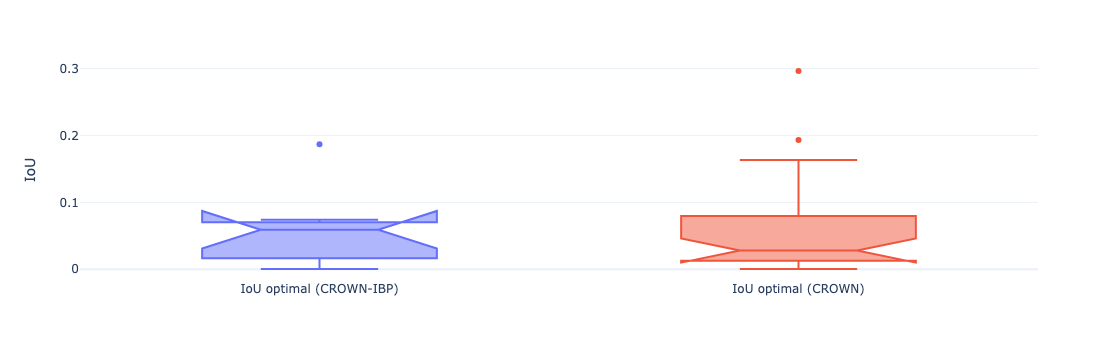

epsilon 0.0014


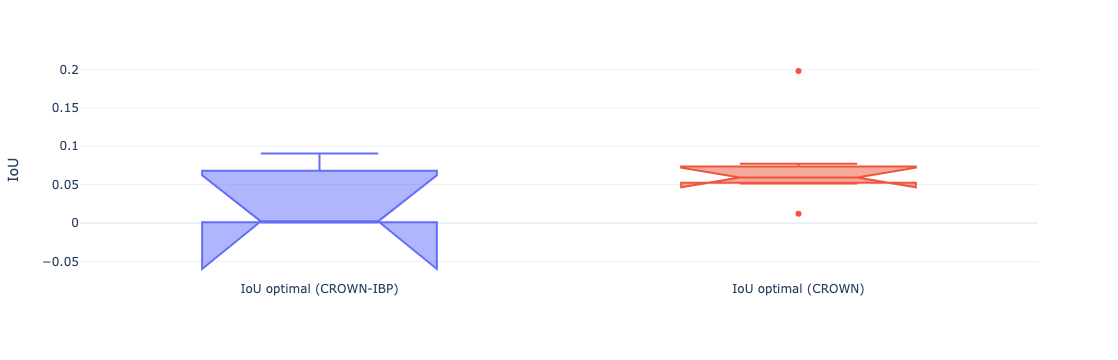

epsilon 0.0016


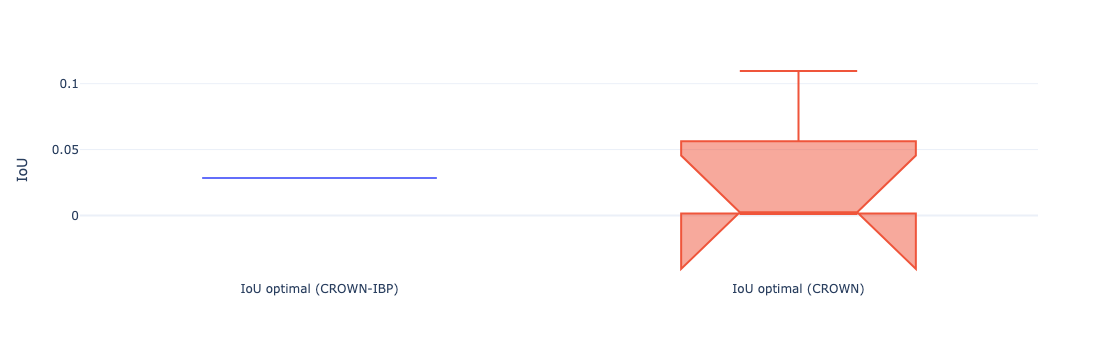

epsilon 0.0018


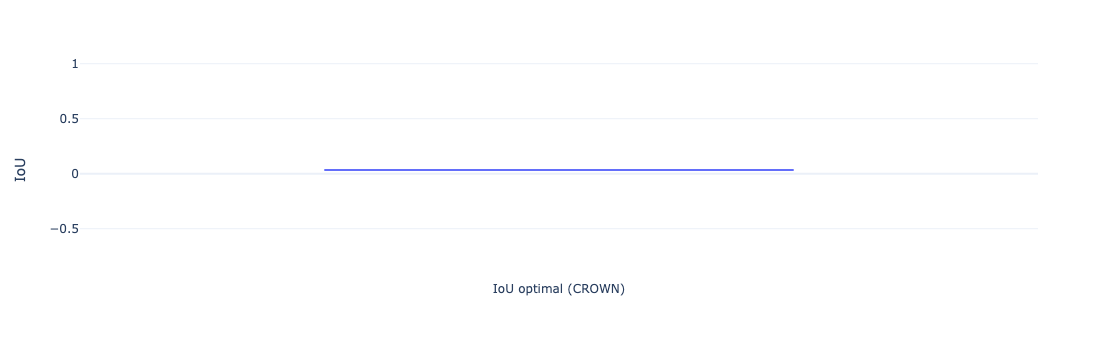

epsilon 0.002


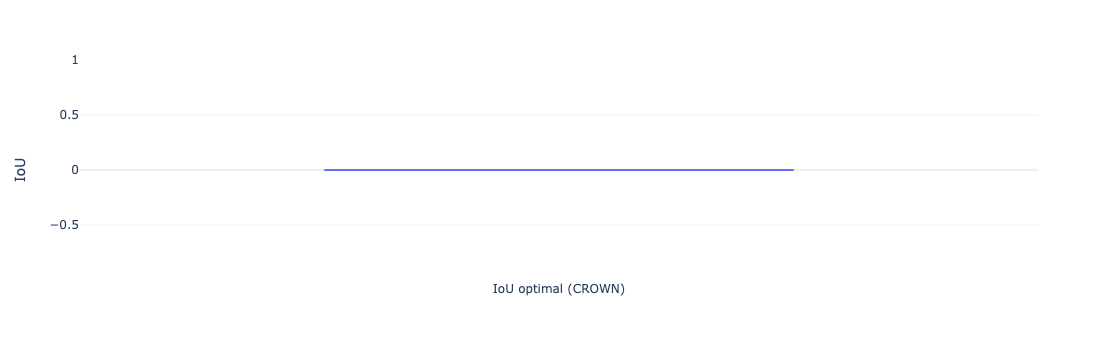

In [37]:
for eps in np.unique(combined_df["eps"]):
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==eps) & (combined_df["perturbation"]=="whitenoise")]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN-IBP)'}), ['IoU optimal (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN)'}), ['IoU optimal (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Extension_lower":'IoU optimal (IBP)'}), ['IoU optimal (IBP)'], return_V=True)
    
    ious = pd.concat([df_CROWN_IBP_iou, df_CROWN_iou, df_IBP_iou])
    
    create_box_plot(ious, columns=[""], return_V=False, without_melt=True, y_axes='IoU')

epsilon 0.0


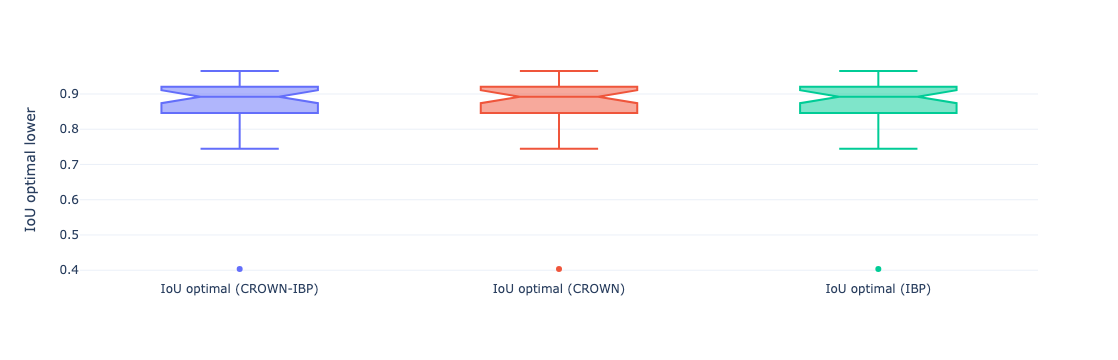

epsilon 0.0002


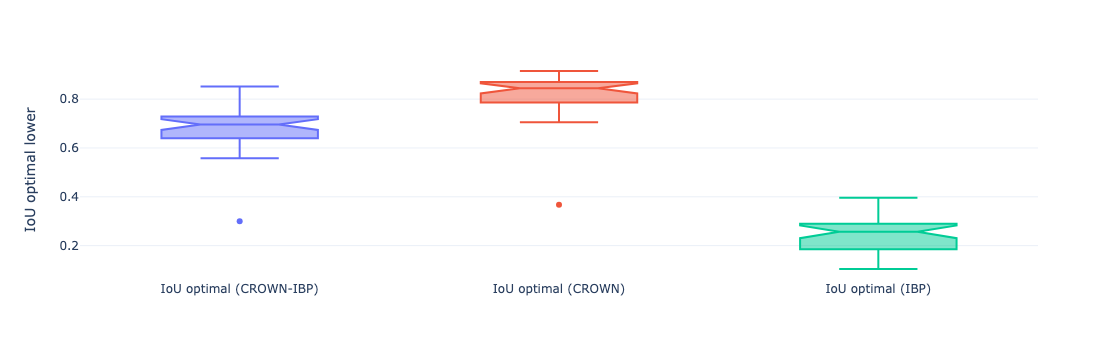

epsilon 0.0004


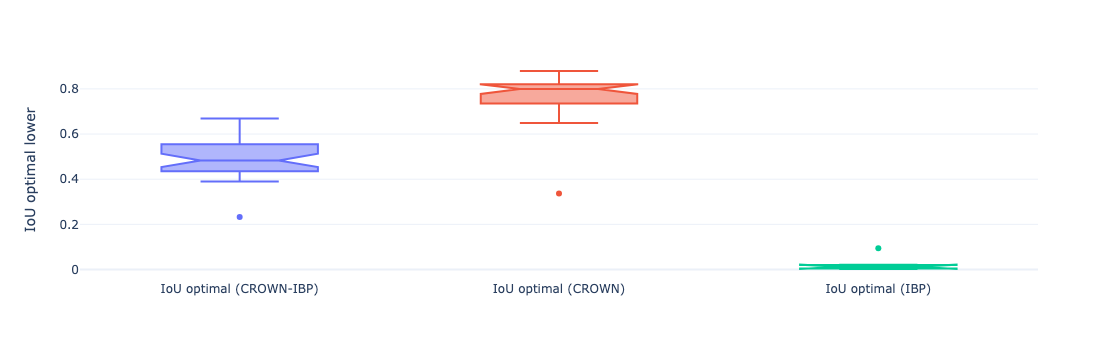

epsilon 0.0006


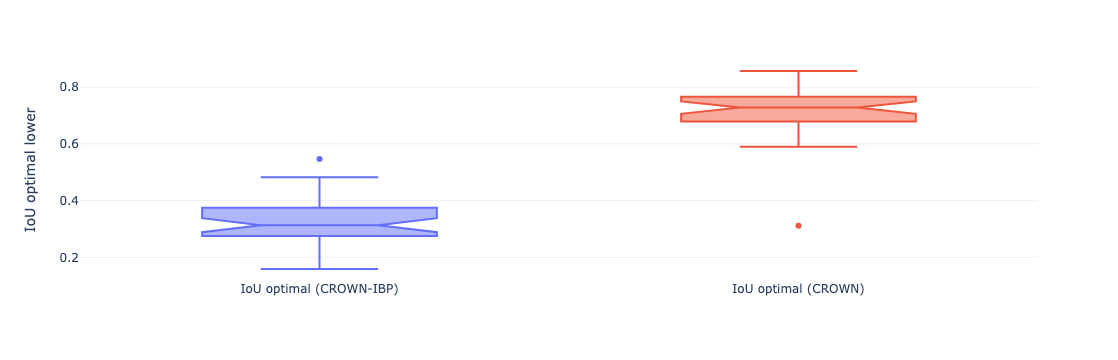

epsilon 0.0008


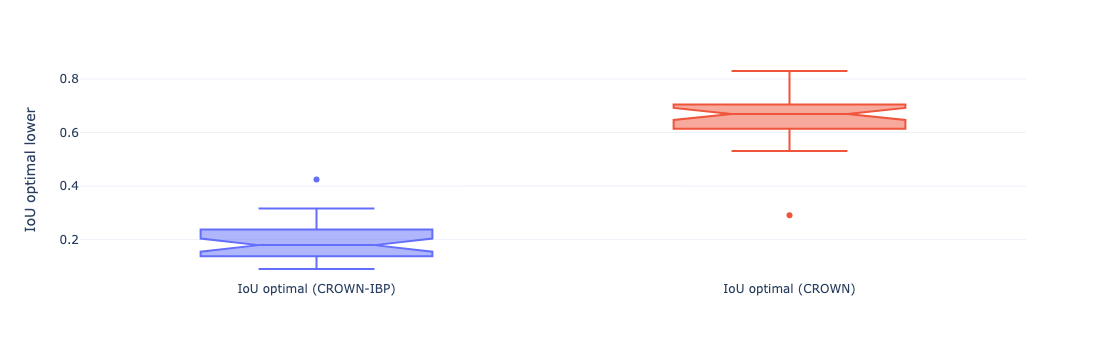

epsilon 0.001


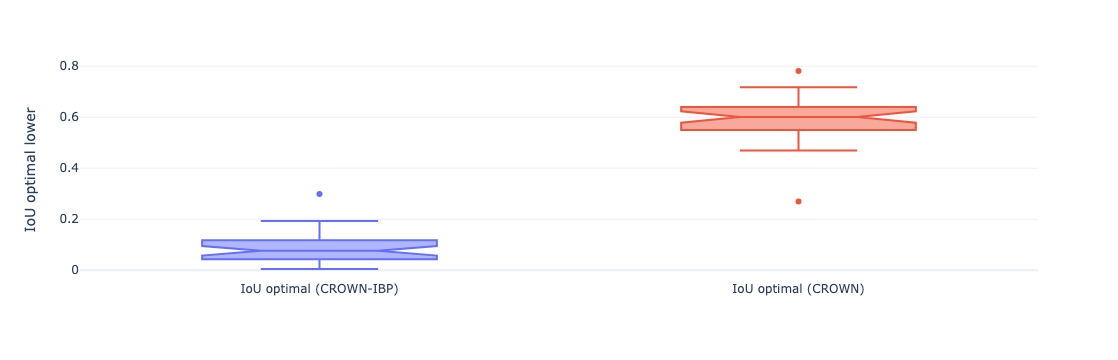

epsilon 0.0012


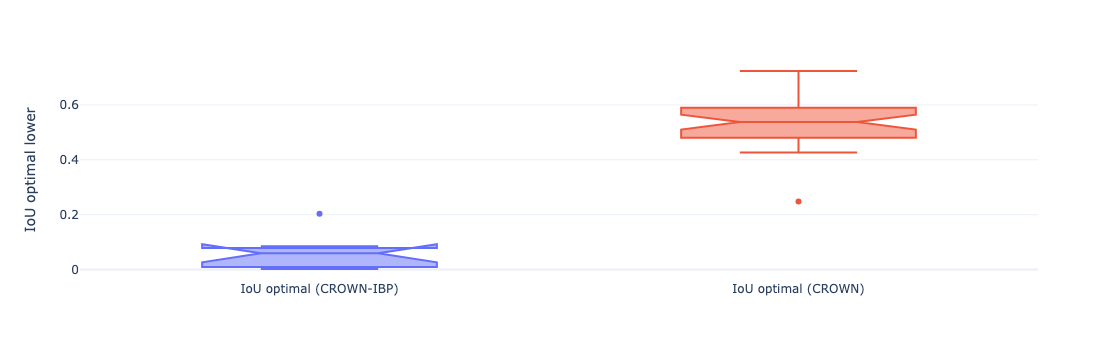

epsilon 0.0014


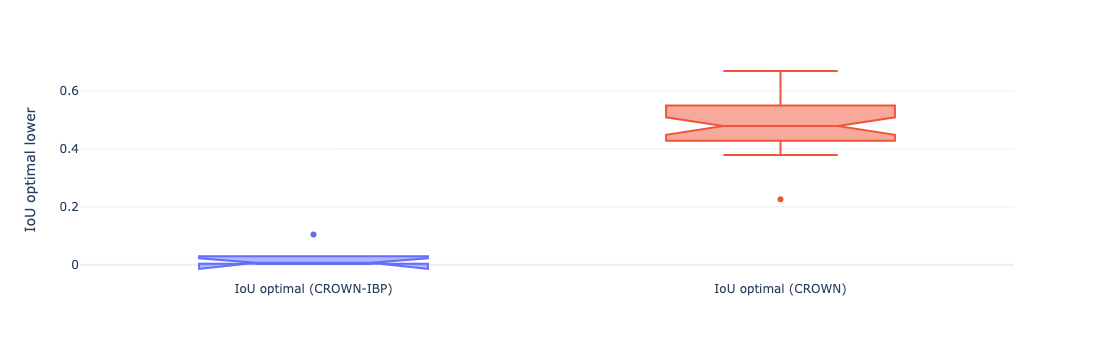

epsilon 0.0016


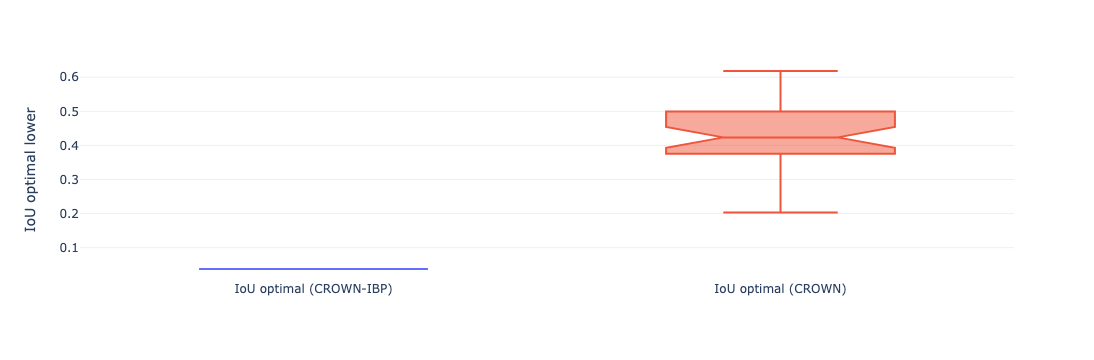

epsilon 0.0018


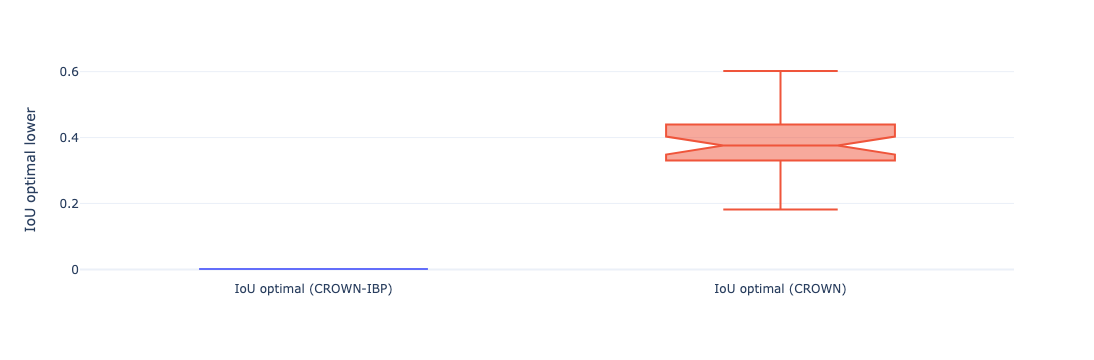

epsilon 0.002


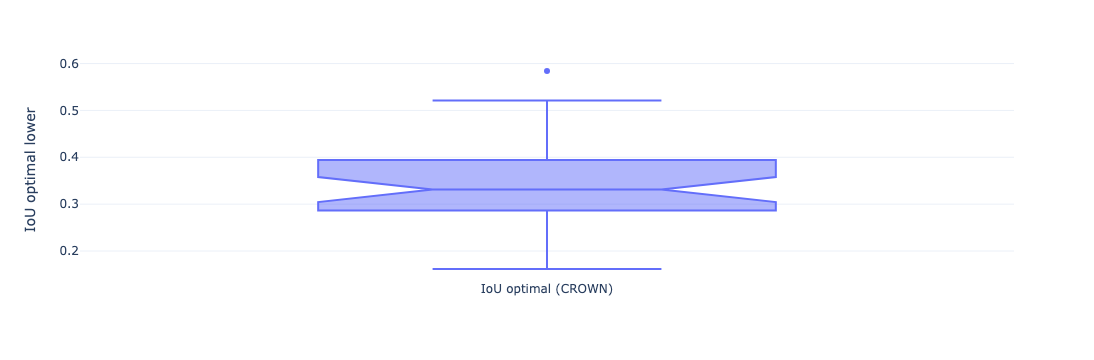

In [50]:

for eps in np.unique(combined_df["eps"]):
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==eps) & (combined_df["perturbation"]=="brightness")]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN-IBP)'}), ['IoU optimal (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN)'}), ['IoU optimal (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Extension_lower":'IoU optimal (IBP)'}), ['IoU optimal (IBP)'], return_V=True)
    
    ious = pd.concat([df_CROWN_IBP_iou, df_CROWN_iou, df_IBP_iou])
    
    create_box_plot(ious, columns=[""], return_V=False, without_melt=True, y_axes='IoU optimal lower')

epsilon_contrast 0.0


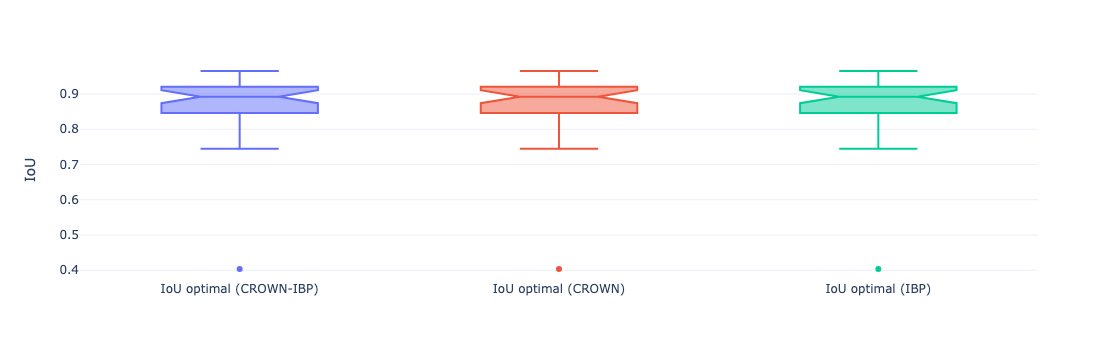

epsilon_contrast 0.001


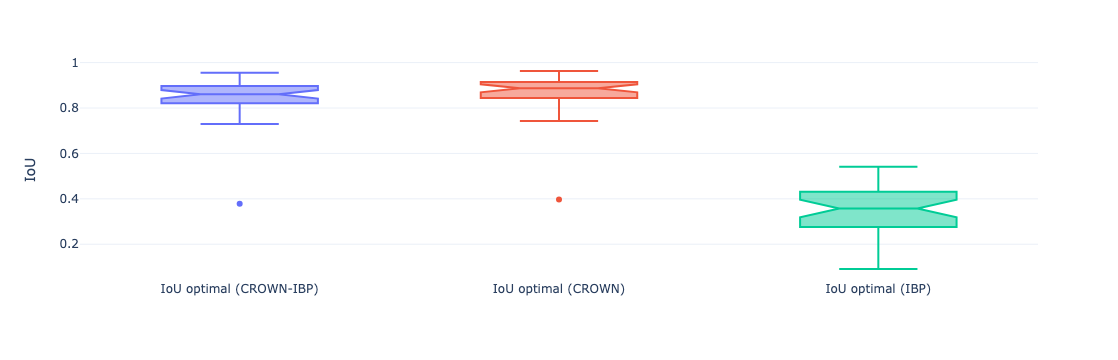

epsilon_contrast 0.002


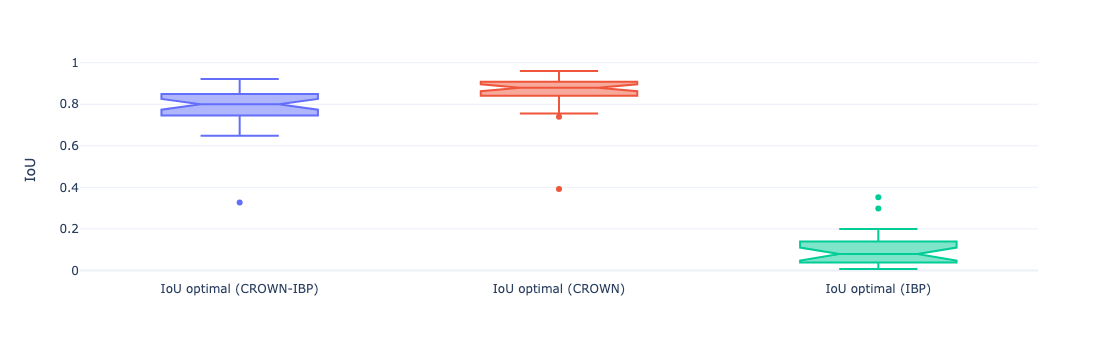

epsilon_contrast 0.003


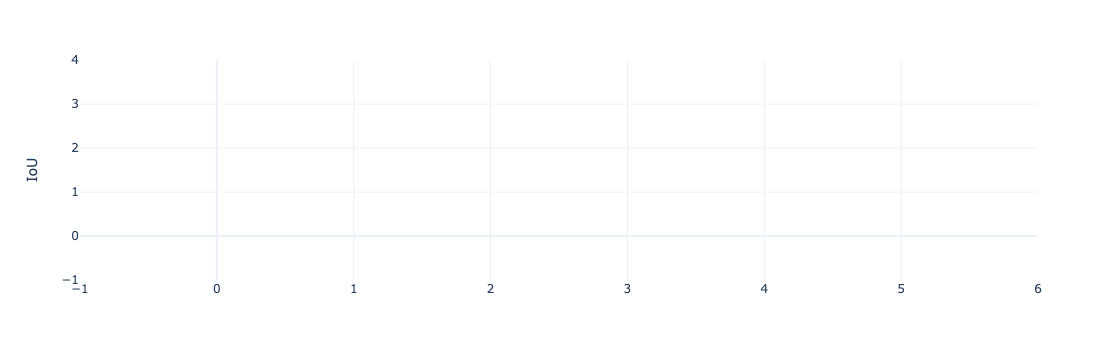

epsilon_contrast 0.004


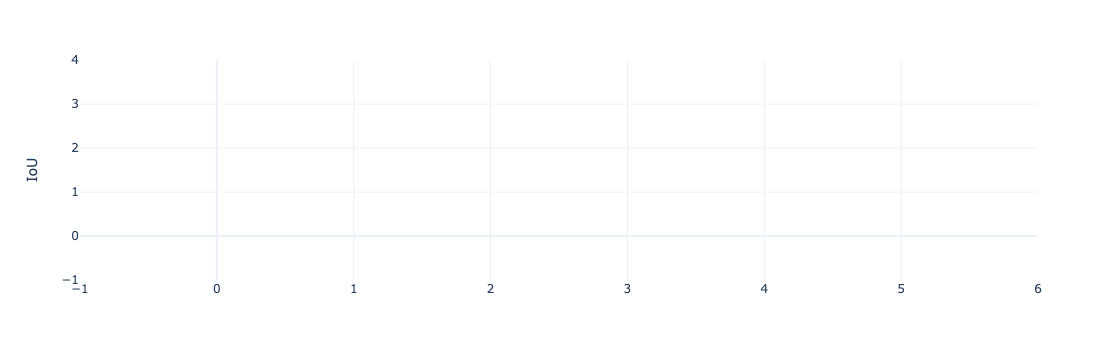

epsilon_contrast 0.005


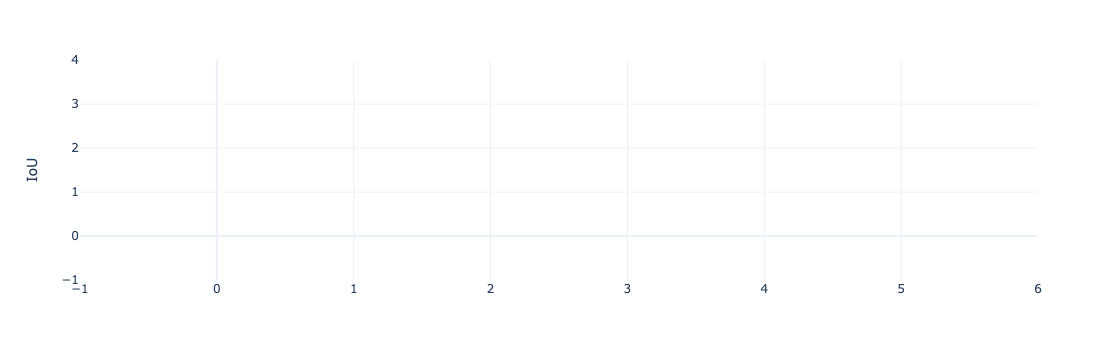

epsilon_contrast 0.006


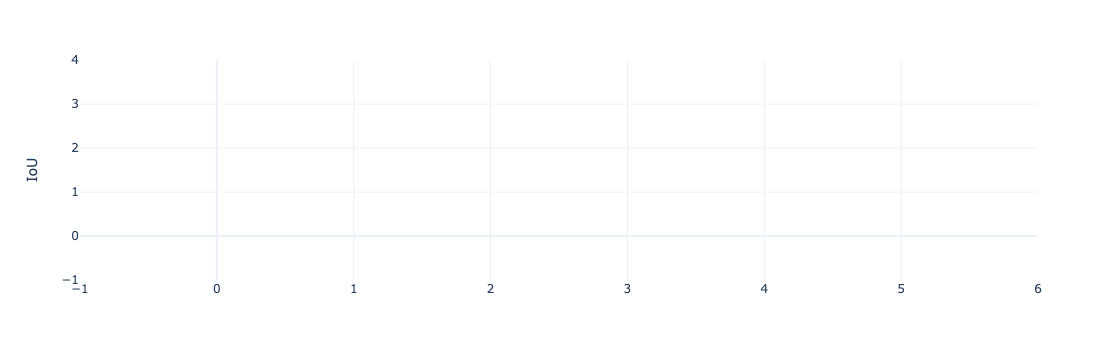

epsilon_contrast 0.007


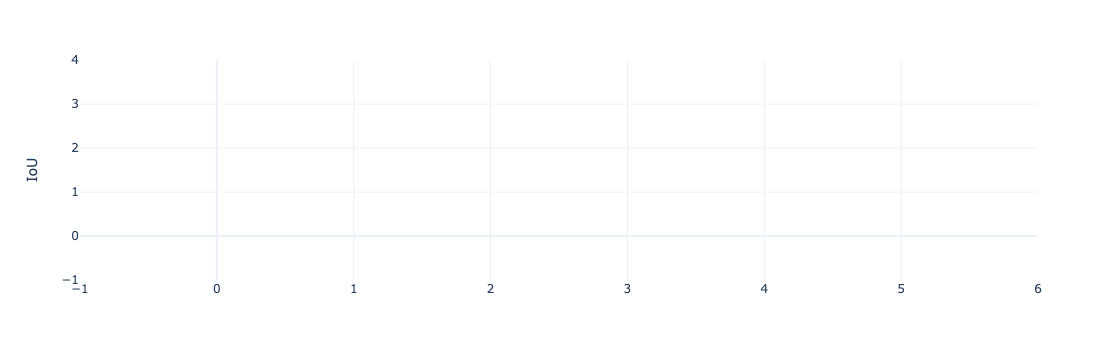

epsilon_contrast 0.008


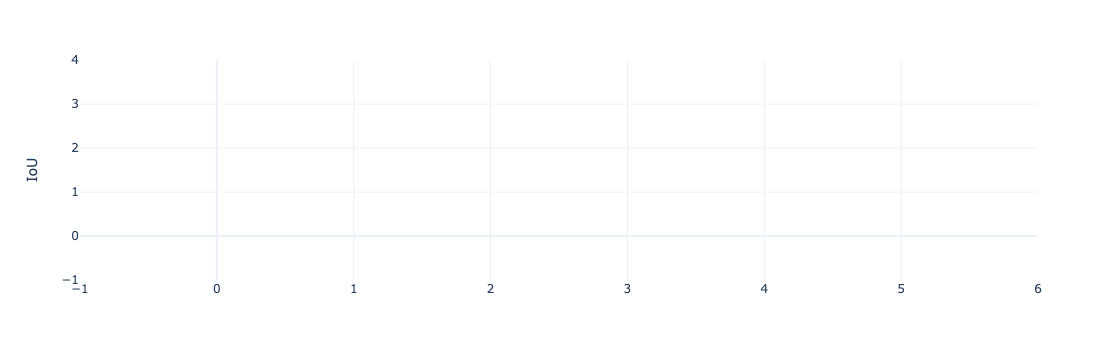

epsilon_contrast 0.009


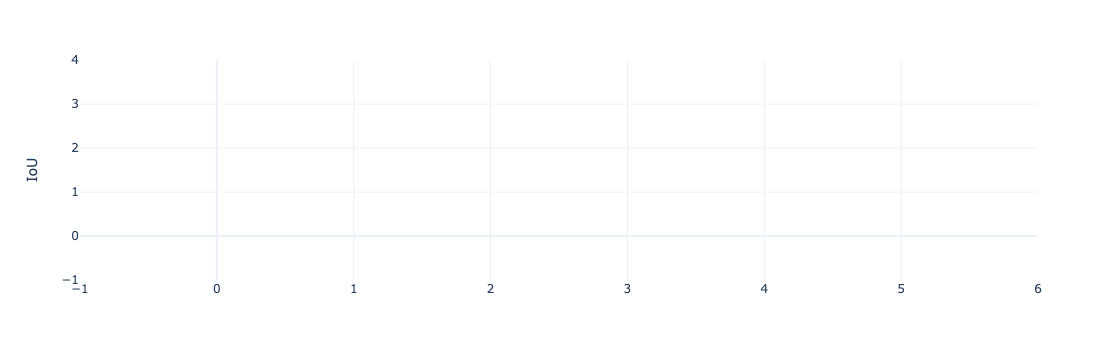

epsilon_contrast 0.01


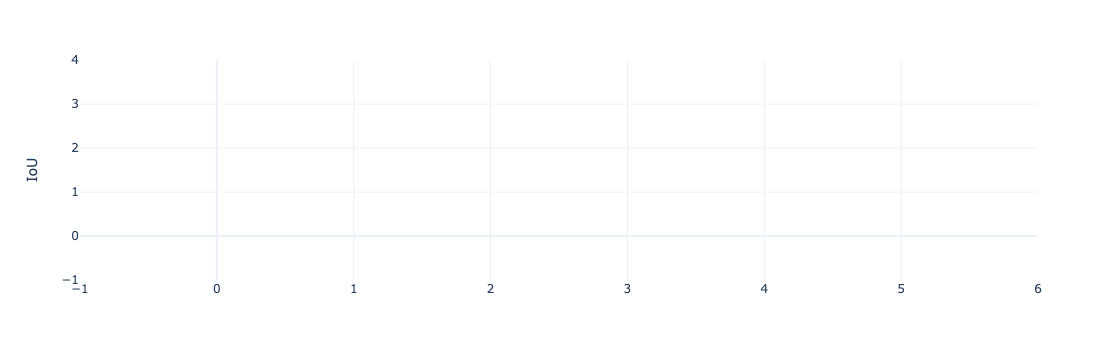

In [38]:
for eps in np.unique(combined_df["eps_contrast"]):
    print("epsilon_contrast", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==eps) & (combined_df["perturbation"]=="contrast")]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN-IBP)'}), ['IoU optimal (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Extension_lower":'IoU optimal (CROWN)'}), ['IoU optimal (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Extension_lower":'IoU optimal (IBP)'}), ['IoU optimal (IBP)'], return_V=True)
    
    ious = pd.concat([df_CROWN_IBP_iou, df_CROWN_iou, df_IBP_iou])
    
    create_box_plot(ious, columns=[""], return_V=False, without_melt=True, y_axes='IoU')

In [52]:
combined_df[(combined_df["fake_iou"]==False)  & (combined_df["perturbation"]=="contrast")].describe()

Unnamed: 0     image_id  gt_logit          eps  eps_contrast  \
count  1297.000000  1297.000000    1297.0  1297.000000   1297.000000   
mean     50.353894    22.037779       0.0     0.000985      0.004923   
std      28.701402    12.674740       0.0     0.000627      0.003135   
min       2.000000     0.000000       0.0     0.000000      0.000000   
25%      26.000000    11.000000       0.0     0.000400      0.002000   
50%      50.000000    22.000000       0.0     0.001000      0.005000   
75%      74.000000    32.000000       0.0     0.001600      0.008000   
max      98.000000    43.000000       0.0     0.002000      0.010000   

       elapsed_time_perturbation  elapsed_time_eps_computed_ious  \
count                1297.000000                     1297.000000   
mean                    8.970328                        0.028494   
std                    14.566945                        0.010519   
min                     0.219252                        0.015032   
25%                     0.273536                        0.016126   
50%                     0.316571                        0.029323   
75%                    13.923433                        0.038218   
max                    52.328279                        0.053121   

       tmps_vanilla  tmps_extension      lb_box0  IoU_vanilla_delta  \
count   1297.000000     1297.000000  1297.000000        1297.000000   
mean       0.000069        0.010435    29.780022           0.271474   
std        0.000011        0.000663    18.113912           0.356371   
min        0.000059        0.009813     0.000000           0.000000   
25%        0.000062        0.010064    12.582052           0.011591   
50%        0.000065        0.010308    32.131565           0.055420   
75%        0.000073        0.010607    45.036205           0.524497   
max        0.000198        0.018857    59.434933           0.999575   

       IoU_extension_delta  Vanilla_upper  Vanilla_lower  Extension_upper  \
count         1.297000e+03    1297.000000    1297.000000      1297.000000   
mean          2.046012e-01       0.924922       0.653448         0.915044   
std           3.023541e-01       0.095058       0.317063         0.096096   
min          -2.955322e-08       0.403496       0.000425         0.403496   
25%           6.520986e-03       0.885402       0.395261         0.874633   
50%           2.950086e-02       0.942312       0.804626         0.929100   
75%           3.191761e-01       1.000000       0.885610         1.000000   
max           9.980777e-01       1.000000       0.965224         1.000000   

       Extension_lower  
count      1297.000000  
mean          0.710443  
std           0.266450  
min           0.001922  
25%           0.618691  
50%           0.833991  
75%           0.893676  
max           0.965224

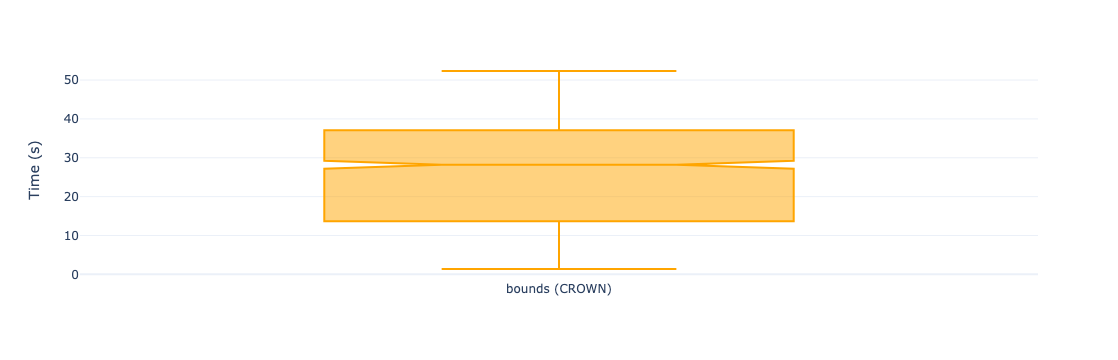

In [39]:
fig = px.box(df_CROWN, x='Time', y='Value', color='Time', 
             notched=True,  
             title='')

fig.update_layout(
    yaxis_title='Time (s)',  
    xaxis_title='',
    template='plotly_white',  
    showlegend=False  
)

fig.update_traces(marker_color='orange', line_color='orange')

## Global analysis IoU

In [40]:
list_bri_white = []
for pert in ["brightness", "whitenoise"]:
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==0.0004) & (combined_df["perturbation"]==pert)]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Extension_lower":f'{pert} (CROWN-IBP)'}), [f'{pert} (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Extension_lower":f'{pert} (CROWN)'}), [f'{pert} (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Extension_lower":f'{pert} (IBP)'}), [f'{pert} (IBP)'], return_V=True)
    list_bri_white.append(df_CROWN_IBP_iou)
    list_bri_white.append(df_CROWN_iou)
    list_bri_white.append(df_IBP_iou)

epsilon 0.01
epsilon 0.01


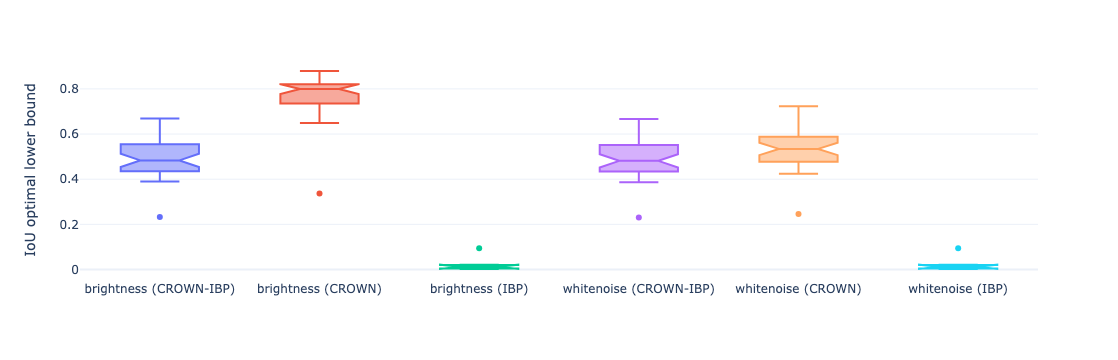

In [41]:
ious_bri_white = pd.concat(list_bri_white)

create_box_plot(ious_bri_white, columns=[""], return_V=False, without_melt=True, y_axes='IoU optimal lower bound')

epsilon 0.01
epsilon 0.01


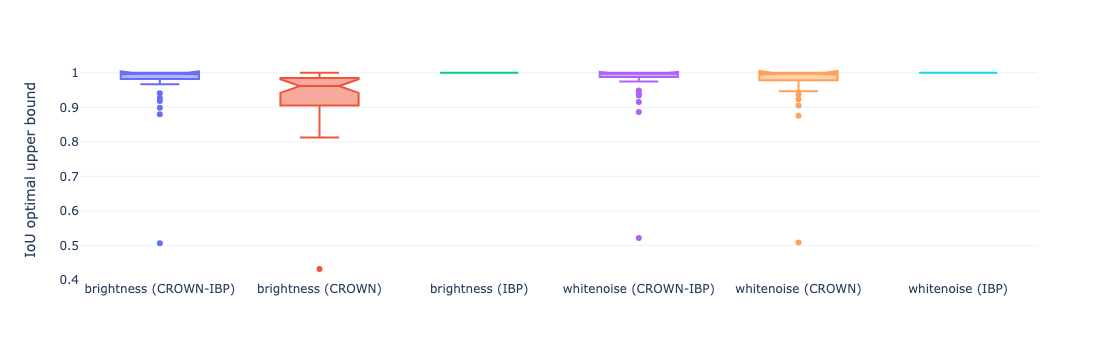

In [42]:
list_bri_white = []
for pert in ["brightness", "whitenoise"]:
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==0.0004) & (combined_df["perturbation"]==pert)]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Extension_upper":f'{pert} (CROWN-IBP)'}), [f'{pert} (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Extension_upper":f'{pert} (CROWN)'}), [f'{pert} (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Extension_upper":f'{pert} (IBP)'}), [f'{pert} (IBP)'], return_V=True)
    list_bri_white.append(df_CROWN_IBP_iou)
    list_bri_white.append(df_CROWN_iou)
    list_bri_white.append(df_IBP_iou)
ious_bri_white = pd.concat(list_bri_white)
create_box_plot(ious_bri_white, columns=[""], return_V=False, without_melt=True, y_axes='IoU optimal upper bound')

epsilon 0.01
epsilon 0.01


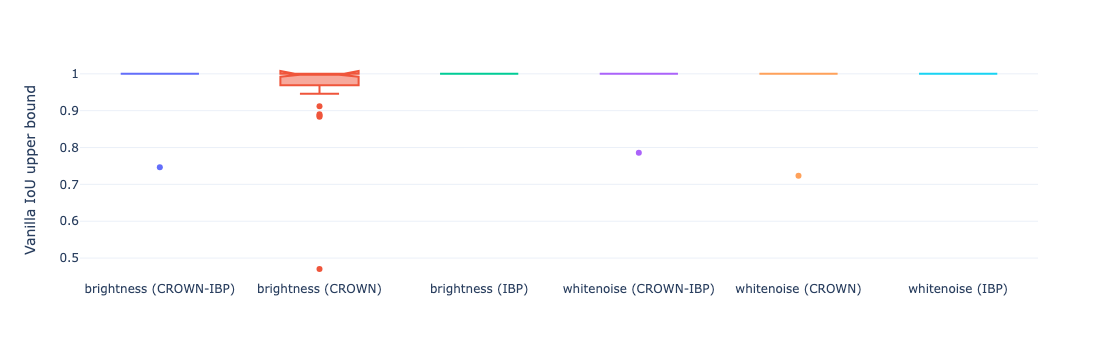

In [43]:
list_bri_white = []
for pert in ["brightness", "whitenoise"]:
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==0.0004) & (combined_df["perturbation"]==pert)]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Vanilla_upper":f'{pert} (CROWN-IBP)'}), [f'{pert} (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Vanilla_upper":f'{pert} (CROWN)'}), [f'{pert} (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Vanilla_upper":f'{pert} (IBP)'}), [f'{pert} (IBP)'], return_V=True)
    list_bri_white.append(df_CROWN_IBP_iou)
    list_bri_white.append(df_CROWN_iou)
    list_bri_white.append(df_IBP_iou)
ious_bri_white = pd.concat(list_bri_white)
create_box_plot(ious_bri_white, columns=[""], return_V=False, without_melt=True, y_axes='Vanilla IoU upper bound')

epsilon 0.01
epsilon 0.01


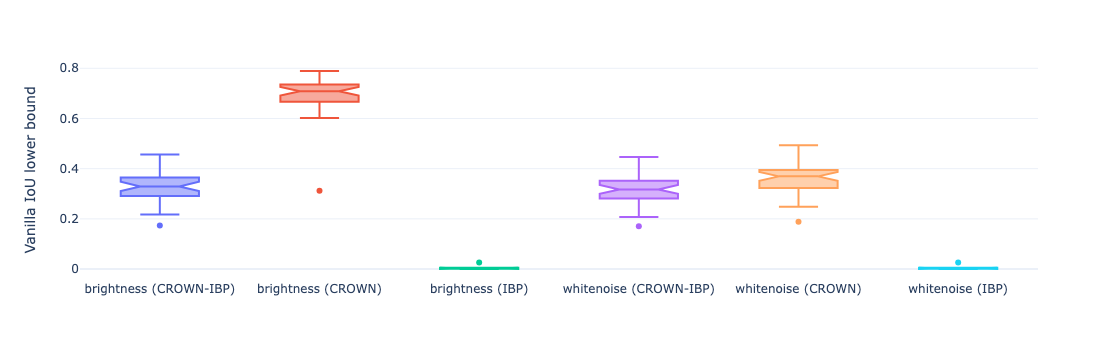

In [58]:
list_bri_white = []
for pert in ["brightness", "whitenoise"]:
    print("epsilon", eps)
    truth_ious = combined_df[(combined_df["fake_iou"]==False) & (combined_df["eps"]==0.0004) & (combined_df["perturbation"]==pert)]
    df_CROWN_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP+backward (CROWN-IBP)'].rename(columns={
        "Vanilla_lower":f'{pert} (CROWN-IBP)'}), [f'{pert} (CROWN-IBP)'], return_V=True)
    df_CROWN_iou = create_box_plot(truth_ious[truth_ious["method"] == 'backward (CROWN)'].rename(columns={
        "Vanilla_lower":f'{pert} (CROWN)'}), [f'{pert} (CROWN)'], return_V=True)
    df_IBP_iou = create_box_plot(truth_ious[truth_ious["method"] == 'IBP'].rename(columns={
        "Vanilla_lower":f'{pert} (IBP)'}), [f'{pert} (IBP)'], return_V=True)
    list_bri_white.append(df_CROWN_IBP_iou)
    list_bri_white.append(df_CROWN_iou)
    list_bri_white.append(df_IBP_iou)
ious_bri_white = pd.concat(list_bri_white)
create_box_plot(ious_bri_white, columns=[""], return_V=False, without_melt=True, y_axes='Vanilla IoU lower bound')

In [66]:
def optimal_up_or_down(x):
    if (x.Vanilla_lower <= 0.5) & (x.Extension_lower >= 0.5):
        return(True)
    else:
        return(False)

combined_df["optimal_up_or_down"] = combined_df.apply(lambda x: optimal_up_or_down(x), axis=1)


9.235315847801996


In [71]:
np.unique(combined_df["method"])

array(['IBP', 'IBP+backward (CROWN-IBP)', 'backward (CROWN)'],
      dtype=object)

In [83]:
nb_optimal_up_or_down = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness") & (combined_df["optimal_up_or_down"] == True) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness")  & (combined_df["fake_iou"] == False)].shape[0]
nb_optimal_up_or_down_percent_bri_CROWN = nb_optimal_up_or_down/nb_total*100
print(nb_optimal_up_or_down/nb_total*100)

22.272727272727273


In [84]:
nb_optimal_up_or_down = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise") & (combined_df["optimal_up_or_down"] == True) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise")  & (combined_df["fake_iou"] == False)].shape[0]
nb_optimal_up_or_down_percent_white_CROWN = nb_optimal_up_or_down/nb_total*100
print(nb_optimal_up_or_down/nb_total*100)

10.801393728222997


In [93]:
name1 = str(round(nb_optimal_up_or_down_percent_white_CROWN,2))+"%"

In [86]:
nb_optimal_up_or_down_percent_bri_CROWN

22.272727272727273

In [94]:
name2 = str(round(nb_optimal_up_or_down_percent_bri_CROWN,2))+"%"

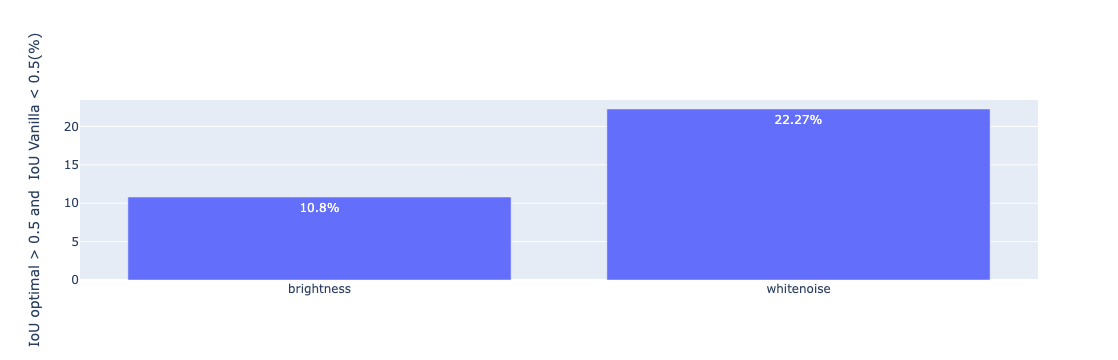

In [96]:
import plotly.graph_objects as go
perturbations=['brightness', 'whitenoise']

fig = go.Figure([go.Bar(x=perturbations, y=[nb_optimal_up_or_down_percent_white_CROWN ,nb_optimal_up_or_down_percent_bri_CROWN], text=[name1, name2])])
fig.update_yaxes(title_text="IoU optimal and IoU Vanilla  (%)")
fig.show()

In [100]:
data1 = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness") & (combined_df["Extension_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness") & (combined_df["fake_iou"] == False)].shape[0]
optimal_sup_bri_CROWN = data1/nb_total*100
print(optimal_sup_bri_CROWN)

65.0


In [101]:
data2 = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness") & (combined_df["Vanilla_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="brightness") & (combined_df["fake_iou"] == False)].shape[0]
vanilla_sup_bri_CROWN = data2/nb_total*100
print(vanilla_sup_bri_CROWN)

42.72727272727273


In [102]:
data3 = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise") & (combined_df["Extension_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise") & (combined_df["fake_iou"] == False)].shape[0]
optimal_sup_white_CROWN = data3/nb_total*100
print(optimal_sup_white_CROWN)

65.0


In [104]:
data2 = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise") & (combined_df["Vanilla_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[(combined_df["method"]=='backward (CROWN)') & (combined_df["perturbation"]=="whitenoise") & (combined_df["fake_iou"] == False)].shape[0]
vanilla_sup_white_CROWN = data2/nb_total*100
print(vanilla_sup_white_CROWN)

26.82926829268293


In [110]:
data4 = combined_df[(combined_df["perturbation"]=="contrast") & (combined_df["Extension_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[ (combined_df["perturbation"]=="contrast") & (combined_df["fake_iou"] == False)].shape[0]
optimal_sup_contrast_CROWN = data4/nb_total*100
print(optimal_sup_contrast_CROWN)

78.7201233616037


In [111]:
data4 = combined_df[(combined_df["perturbation"]=="contrast") & (combined_df["Vanilla_lower"] >= 0.5) & (combined_df["fake_iou"] == False)].shape[0]
nb_total = combined_df[ (combined_df["perturbation"]=="contrast") & (combined_df["fake_iou"] == False)].shape[0]
vanilla_sup_contrast_CROWN = data4/nb_total*100
print(vanilla_sup_contrast_CROWN)

72.78334618350038
